# Comparative analysis with competing algorithms

In [1]:
import theano
theano.config.warn.round=False
import pymc3 as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# data
np.random.seed(663)

N = 10000
theta1 = -3; theta2 = 3
z = np.random.choice(2, N, p=[0.5,0.5])
xs = np.zeros((N, 1))

for i in range(N):
    if z[i] == 1:
        xs[i] = np.random.randn(1) + theta1
    else:
        xs[i] = np.random.randn(1) + theta2

## Pymc3

In [3]:
niter = 500
with pm.Model() as gaussian_mixture:
    mu = pm.MvNormal('mu', mu = np.zeros(2), cov=10*np.eye(2), shape=(1,2))
    x = pm.NormalMixture('x', w=np.array([.5,.5]),
                         mu=mu, sigma=np.array([1, 1]), 
                         observed=xs)
    trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:09<00:00, 411.83draws/s]
The acceptance probability does not match the target. It is 0.8800974675270462, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958324398803484, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


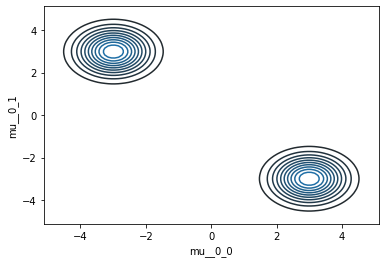

In [4]:
df = pm.trace_to_dataframe(trace)
sns.kdeplot(df.iloc[:,0], df.iloc[:,1])
plt.savefig('Pymc.png')
pass

## PyStan

In [5]:
import pystan

In [6]:
gaussian_mixture = '''
data {
    int N;
    vector[N] xs;
    int n_groups;
    vector<lower = 0>[n_groups] sigma;
    vector<lower=0>[n_groups]  weights;
}
parameters {
    vector[n_groups] mu;
}
model {
      vector[n_groups] contributions;
      // priors
      mu ~ normal(0, 10);
      
      // likelihood
      for(i in 1:N) {
        for(k in 1:n_groups) {
          contributions[k] = log(weights[k]) + normal_lpdf(xs[i] | mu[k], sigma[k]);
        }
        target += log_sum_exp(contributions);
      }
}
'''

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_886d26bbb904f423b760011c077445f3 NOW.


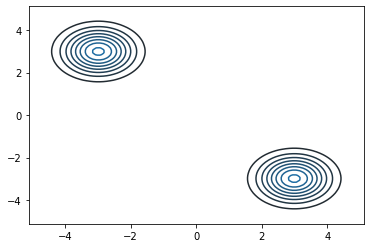

In [7]:
data = {
    'N': len(xs),
    'xs': xs.flatten(),
    'n_groups': 2,
    'sigma': np.array([1.0, 1.0]),
    'weights': np.array([.5, .5])
}
    
sm = pystan.StanModel(model_code=gaussian_mixture)
fit = sm.sampling(data = data, iter=1000, chains=4)

samples = fit.extract(permuted=True)['mu']
sns.kdeplot(samples[:,0], samples[:,1])
pass